In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannawang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Preprocessing

In [18]:
raw_text = pd.read_csv('../Data/final_top20.csv').dropna()  # includes lifestyle and others, need filtering first
wikis = pd.read_csv('../Data/final_wikis.csv')
text_1191 = raw_text[raw_text['wiki_id'].isin(wikis.wiki_id)].\
                        groupby('wiki_id').agg({'title':lambda x:list(x), 
                                                'content':lambda x:' '.join(x)}).reset_index()
for idx, row in text_1191.iterrows():
    if len(row.content.split(' ')) < 10000:
        text_1191.drop(idx, inplace=True)
display(text_1191.head())
len(text_1191)

In [ ]:
# replace title in content
for idx, row in text_1191.iterrows():
    for tit in row.title:
        if tit.endswith('_Wiki'): tit = tit[:-5]
        tit = tit.replace('_', ' ').lower()
        text_1191.at[idx, 'content'] = text_1191.at[idx, 'content'].lower().replace(tit, '')

In [ ]:
text_1191.head()

In [ ]:
# https://gist.github.com/ryanmcgrath/982242
# https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row

# UNICODE RANGE : DESCRIPTION

# 3000-303F : punctuation
# 3040-309F : hiragana
# 30A0-30FF : katakana
# FF00-FFEF : Full-width roman + half-width katakana
# 4E00-9FAF : Common and uncommon kanji

# Non-Japanese punctuation/formatting characters commonly used in Japanese text
# 2605-2606 : Stars
# 2190-2195 : Arrows
# u203B     : Weird asterisk thing


japan = r"[\u3000-\u303F]|[\u3040-\u309F]|[\u30A0-\u30FF]|[\uFF00-\uFFEF]|[\u4E00-\u9FAF]|[\u2605-\u2606]|[\u2190-\u2195]|\u203B+"
reg_japan = re.compile(japan)

# detect japanese words in content and replace with space
japan_content = []
for i, row in text_1191.iterrows():
    text = getattr(row, 'content')
    japan_content.append(len(reg_japan.findall(str(text))))
    text_1191.at[i, 'content'] = re.sub(japan, " ", str(text))

In [ ]:
# normalize text, one step before stem
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
porter = PorterStemmer()


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    digit_free = ''.join(ch for ch in stop_free if not ch.isdigit())
    symbol_free = re.sub(r'[^\w]', ' ', digit_free)
    punc_free = ''.join(ch for ch in symbol_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    stemmed = " ".join(porter.stem(word) for word in normalized.split())
    morethantwo = " ".join(
        word for word in stemmed.split() if len(word) > 2)
    return morethantwo

In [ ]:
stem_text = text_1191.copy()
for i, row in stem_text.iterrows():
    text = getattr(row, 'content')
    stem_text.at[i, 'content'] = clean(text)

In [ ]:
stem_text.head()

In [19]:
stem_text.to_csv('stem_text.csv', index=False)

## LDA in gensim

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### Prepare stopwords

In [4]:
stem_text = pd.read_csv('stem_text.csv')

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Data

In [6]:
# Convert to data list
data = stem_text.content.values.tolist()
data_words = [d.split(' ') for d in data]

print(data_words[:1])

[['welcom', 'babylon', 'project', 'comprehens', 'encyclopedia', 'univers', 'articl', 'articl', 'sinc', 'decemb', 'alfr', 'bester', 'senior', 'psi', 'corp', 'offic', 'one', 'notori', 'psi', 'cop', 'level', 'investig', 'bester', 'born', 'secret', 'locat', 'parent', 'matthew', 'fiona', 'dexter', 'resist', 'leader', 'both', 'hide', 'pursuit', 'power', 'telepath', 'name', 'jason', 'ironheart', 'first', 'arriv', 'bester', 'eventu', 'agre', 'work', 'captain', 'sever', 'point', 'second', 'war', 'particularli', 'captur', 'bester', 'pregnant', 'lover', 'carolyn', 'sanderson', 'wealthi', 'industrialist', 'william', 'edgar', 'perfect', 'lethal', 'viru', 'would', 'attack', 'telepath', 'uniqu', 'gene', 'infect', 'telepath', 'would', 'quickli', 'die', 'without', 'regular', 'antidot', 'also', 'creat', 'bester', 'brainwash', 'michael', 'garibaldi', 'program', 'enter', 'edgar', 'confid', 'kill', 'edgar', 'acquir', 'viru', 'remov', 'command', 'left', 'garibaldi', 'cope', 'realiz', 'betray', 'everyon', 'k

### Creating Bigram and Trigram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=300) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=300)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/envs/ml/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['welcom', 'babylon', 'project', 'comprehens_encyclopedia', 'univers', 'articl', 'articl', 'sinc', 'decemb', 'alfr_bester', 'senior', 'psi_corp', 'offic', 'one', 'notori', 'psi', 'cop', 'level', 'investig', 'bester', 'born', 'secret', 'locat', 'parent', 'matthew', 'fiona', 'dexter', 'resist', 'leader', 'both', 'hide', 'pursuit', 'power', 'telepath', 'name', 'jason', 'ironheart', 'first', 'arriv', 'bester', 'eventu', 'agre', 'work', 'captain', 'sever', 'point', 'second', 'war', 'particularli', 'captur', 'bester', 'pregnant', 'lover', 'carolyn', 'sanderson', 'wealthi_industrialist', 'william', 'edgar', 'perfect', 'lethal', 'viru', 'would', 'attack', 'telepath', 'uniqu', 'gene', 'infect', 'telepath', 'would', 'quickli', 'die', 'without', 'regular', 'antidot', 'also', 'creat', 'bester', 'brainwash', 'michael', 'garibaldi', 'program', 'enter', 'edgar', 'confid', 'kill', 'edgar', 'acquir', 'viru', 'remov', 'command', 'left', 'garibaldi', 'cope', 'realiz', 'betray', 'everyon', 'knew', 'side',

In [8]:
gram = [k for k in trigram_mod[bigram_mod[data_words[0]]] if '_' in k]
np.unique(gram)

array(['achil_heel', 'add_photo', 'add_photo_galleri', 'adira_tyre',
       'advisori_council', 'alfr_bester', 'anla_shok', 'anxious_await',
       'apollo_artemi', 'apolog_profus', 'arous_suspicion',
       'atroc_commit', 'badli_injur', 'bat_mitzvah', 'bid_farewel',
       'biped_humanoid', 'boobi_trap', 'carlo_ramirez', 'centauri_narn',
       'centauri_prime', 'centauri_republ', 'chief_zack_allan',
       'chin_chin', 'circumstanti_evid', 'cite_error_ref_tag',
       'civil_unrest', 'coloni_expans_farscap', 'commit_atroc',
       'commit_suicid', 'comprehens_encyclopedia', 'cryogen_frozen',
       'dalai_lama', 'diametr_opposit', 'diplomat_attaché',
       'distress_signal', 'docker_guild', 'eastern_seaboard',
       'eidet_memori', 'elizabeth_lochley', 'elizabeth_lochley_vir_cotto',
       'entil_zha', 'epsilon_eridani', 'expeditionari_fleet',
       'extern_link', 'facto_leader', 'fell_deaf_ear', 'fore_aft',
       'gender_femal', 'gender_male', 'geniu_locu', 'glow_brightli',
   

### Make Bigrams/Trigrams and then Lemmatize

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
max([len(t) for t in stem_text.content.values.tolist()])

3280595

In [11]:
# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'], max_length=4000000)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['welcom', 'babylon', 'project', 'comprehen', 'encyclopedia', 'univer', 'articl', 'articl', 'sinc', 'decemb', 'alfr_bester', 'senior', 'psi', 'corp', 'offic', 'notori', 'psi', 'cop', 'level', 'bear', 'secret', 'locat', 'parent', 'matthew', 'fiona', 'dexter', 'resist', 'leader', 'hide', 'pursuit', 'power', 'telepath', 'name', 'jason', 'ironheart', 'first', 'arriv', 'eventu', 'agre', 'work', 'captain', 'sever', 'point', 'second', 'war', 'particularli', 'captur', 'pregnant', 'lover', 'carolyn', 'sanderson', 'wealthi_industrialist', 'william', 'edgar', 'perfect', 'lethal', 'viru', 'would', 'attack', 'telepath', 'uniqu', 'gene', 'infect', 'telepath', 'would', 'quickli', 'die', 'regular', 'antidot', 'also', 'creat', 'brainwash', 'michael', 'garibaldi', 'program', 'enter', 'edgar', 'confid', 'kill', 'edgar', 'acquir', 'viru', 'remov', 'command', 'leave', 'garibaldi', 'cope', 'realiz', 'betray', 'everyon', 'know', 'side', 'follow', 'telepath', 'war', 'alfr_bester', 'want', 'war', 'crime', 'co

### Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 69), (1, 11), (2, 9), (3, 2), (4, 3), (5, 2), (6, 1), (7, 1), (8, 25), (9, 1), (10, 66), (11, 1), (12, 13), (13, 1), (14, 1), (15, 2), (16, 1), (17, 8), (18, 1), (19, 3), (20, 1), (21, 3), (22, 7), (23, 4), (24, 19), (25, 2), (26, 3), (27, 2), (28, 38), (29, 9), (30, 8), (31, 2), (32, 3), (33, 2), (34, 16), (35, 6), (36, 12), (37, 1), (38, 2), (39, 15), (40, 2), (41, 4), (42, 11), (43, 2), (44, 1), (45, 7), (46, 5), (47, 1), (48, 6), (49, 47), (50, 30), (51, 22), (52, 1), (53, 18), (54, 1), (55, 3), (56, 1), (57, 4), (58, 2), (59, 10), (60, 1), (61, 19), (62, 4), (63, 1), (64, 1), (65, 3), (66, 6), (67, 1), (68, 7), (69, 1), (70, 3), (71, 4), (72, 4), (73, 42), (74, 1), (75, 2), (76, 5), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 25), (83, 9), (84, 1), (85, 6), (86, 1), (87, 19), (88, 1), (89, 4), (90, 1), (91, 9), (92, 5), (93, 12), (94, 7), (95, 3), (96, 4), (97, 1), (98, 5), (99, 37), (100, 1), (101, 34), (102, 12), (103, 1), (104, 35), (105, 1), (106, 9), (107, 21), (1

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 69),
  ('abandon', 11),
  ('abbai', 9),
  ('abbut', 2),
  ('abduct', 3),
  ('abel', 2),
  ('abhor', 1),
  ('abid', 1),
  ('abil', 25),
  ('abject', 1),
  ('abl', 66),
  ('abnorm', 1),
  ('aboard', 13),
  ('about', 1),
  ('abov', 1),
  ('abrahamo', 2),
  ('abroad', 1),
  ('absenc', 8),
  ('absent', 1),
  ('absolut', 3),
  ('absorb', 1),
  ('abstain', 3),
  ('abyss', 7),
  ('academ', 4),
  ('academi', 19),
  ('acc', 2),
  ('acceler', 3),
  ('accent', 2),
  ('accept', 38),
  ('access', 9),
  ('accid', 8),
  ('accident', 2),
  ('acclim', 3),
  ('accommod', 2),
  ('accompani', 16),
  ('accomplish', 6),
  ('accord', 12),
  ('accost', 1),
  ('account', 2),
  ('accus', 15),
  ('accustom', 2),
  ('acheron', 4),
  ('achiev', 11),
  ('achil', 2),
  ('achil_heel', 1),
  ('acknowledg', 7),
  ('acolyt', 5),
  ('acquaint', 1),
  ('acquir', 6),
  ('act', 47),
  ('action', 30),
  ('activ', 22),
  ('actor', 1),
  ('actual', 18),
  ('adag', 1),
  ('adam', 3),
  ('adamantli', 1),
  ('adapt', 

### Building the Topic Model

In [14]:
# Build LDA model
# https://stackoverflow.com/questions/50805556/understanding-parameters-in-gensim-lda-model

# default: num_topics=100, distributed=False, chunksize=2000, passes=1, update_every=1, 
# alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001

# Alpha is the hyper parameter for the Dirichlet prior. The Dirichlet prior is the distribution from which we draw theta. 
# And theta becomes the parameter that decides what shape the topic distribution is. So essentially, 
# alpha influences how we draw topic distributions.
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=26, 
                                            random_state=100,
                                            update_every=1,  # update_every determines how often the model parameters should be updated
                                            chunksize=100,  # chunksize is the number of documents to be used in each training chunk
                                            passes=10,  # passes is the total number of training passes
                                            alpha='auto',  # alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.
                                            per_word_topics=True)  # setting this to True allows for extraction of the most likely topics given a word. The training process is set in such a way that every word will be assigned to a topic. Otherwise, words that are not indicative are going to be omitted.

### View the topics in LDA model

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(25,
  '0.008*"ninja" + 0.006*"movi" + 0.005*"ghost" + 0.005*"knight" + '
  '0.005*"pack" + 0.005*"citi" + 0.005*"chương" + 0.004*"lego" + '
  '0.004*"warrior" + 0.004*"doctor"'),
 (6,
  '0.035*"tht" + 0.023*"emili" + 0.020*"spencer" + 0.019*"hnn" + 0.011*"van" + '
  '0.011*"lison" + 0.010*"meet" + 0.010*"tobi" + 0.008*"het" + 0.007*"haar"'),
 (3,
  '0.062*"cat" + 0.016*"een" + 0.015*"toru" + 0.014*"beck" + 0.014*"jade" + '
  '0.011*"aan" + 0.010*"ladybug" + 0.010*"zijn" + 0.009*"robbi" + '
  '0.008*"alibaba"'),
 (1,
  '0.023*"week" + 0.014*"jason" + 0.011*"lincoln" + 0.008*"jan" + '
  '0.008*"perci" + 0.007*"piper" + 0.007*"aug" + 0.007*"may" + 0.006*"edit" + '
  '0.006*"juli"'),
 (17,
  '0.019*"quest" + 0.016*"locat" + 0.011*"collect" + 0.011*"clari" + '
  '0.009*"gem" + 0.008*"item" + 0.008*"level" + 0.007*"forest" + 0.006*"total" '
  '+ 0.006*"ancient"'),
 (10,
  '0.008*"king" + 0.008*"mari" + 0.006*"cersei" + 0.006*"jon" + 0.005*"sansa" '
  '+ 0.005*"son" + 0.005*"hous" + 0.005*"

In [16]:
lda_model[corpus[0]]

([(0, 0.018133672),
  (4, 0.36616892),
  (7, 0.014916147),
  (10, 0.17991464),
  (12, 0.15937114),
  (14, 0.052554313),
  (16, 0.032853786),
  (18, 0.032878116),
  (20, 0.10855424),
  (24, 0.019062562)],
 [(0, [4, 14, 10, 16, 18, 24, 12, 7, 22, 20, 23]),
  (1, [4, 10, 12, 14, 20, 18, 16, 7, 24, 9, 13]),
  (2, [10]),
  (3, [10]),
  (4, [4, 10, 18, 12, 16, 24]),
  (5, [18, 16, 4, 24, 9, 20]),
  (6, [4, 20, 7]),
  (7, [4, 16, 7, 20, 24]),
  (8, [4, 16, 12, 20, 18, 7, 13, 5, 8, 9, 22]),
  (9, [20, 7]),
  (10, [4, 16, 18, 12, 20, 10, 14, 7, 9, 24, 13, 22, 0]),
  (11, [12, 16, 4]),
  (12, [12, 4, 0]),
  (13, [4, 14, 20, 16, 7]),
  (14, [20, 4, 9, 16, 7, 18, 0, 13]),
  (15, [12]),
  (16, [20, 4, 24, 7, 14, 16, 18]),
  (17, [4, 10, 20, 18, 16, 14, 24, 7, 22]),
  (18, [18, 4, 10, 24, 16]),
  (19, [4, 12, 20, 16, 10, 7, 14, 18, 24, 9]),
  (20, [4, 16, 12, 18, 7]),
  (21, [4, 18, 24]),
  (22, [12, 20, 16, 18, 4, 7, 5]),
  (23, [12, 4, 24, 16, 20, 22, 14, 18]),
  (24, [12, 20, 16, 24, 22, 18, 9, 0

### Compute Model Perplexity and Coherence Score

https://zhuanlan.zhihu.com/p/33053850

In [40]:
# Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42199756956944834


### Visualize the topics-keywords

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/envs/ml/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.165819 -0.044615       1        1  12.228716
24    -0.101779 -0.136427       2        1  12.066700
4     -0.159444 -0.099585       3        1  11.162968
14    -0.140123 -0.148104       4        1   7.990086
0     -0.044840  0.053557       5        1   5.469846
9     -0.089298  0.133772       6        1   5.311787
5     -0.044877  0.220857       7        1   4.647101
20    -0.095074  0.060246       8        1   4.473560
13    -0.108529  0.160178       9        1   4.308856
18    -0.114242 -0.113482      10        1   4.241539
11    -0.043390  0.186448      11        1   3.942386
2     -0.065722  0.008311      12        1   3.465865
7     -0.084548 -0.029725      13        1   3.192784
21    -0.120427 -0.034128      14        1   2.632759
22    -0.072567 -0.072086      15        1   2.455772
12     0.005604  0.073347      16        1   1.989243
15     0.000657  0.007703      17        1   1.949705
10    -0.016544 -0.170892      18        1   1.513217
23     0.043051 -0.088405      19        1   1.466082
19     0.050566 -0.153222      20        1   1.123069
8      0.088362  0.184852      21        1   1.038654
6      0.361093 -0.096474      22        1   0.848176
17     0.114661  0.174639      23        1   0.842818
25     0.276311  0.044153      24        1   0.612475
1      0.273736 -0.074116      25        1   0.521581
3      0.253185 -0.046803      26        1   0.504253, topic_info=       Category           Freq               Term          Total  loglift  \
1563    Default   77255.000000             episod   77255.000000  30.0000   
1922    Default   86750.000000               game   86750.000000  29.0000   
4568    Default  108793.000000               tell  108793.000000  28.0000   
74244   Default   23152.000000              coord   23152.000000  27.0000   
6216    Default   50766.000000             player   50766.000000  26.0000   
2657    Default   57524.000000              level   57524.000000  25.0000   
7139    Default   19234.000000                cat   19234.000000  24.0000   
3985    Default   96994.000000                say   96994.000000  23.0000   
1089    Default   39394.000000              damag   39394.000000  22.0000   
5557    Default   40466.000000             dragon   40466.000000  21.0000   
309     Default   77486.000000             attack   77486.000000  20.0000   
1743    Default   63109.000000              fight   63109.000000  19.0000   
2544    Default   78862.000000               kill   78862.000000  18.0000   
3099    Default   22761.000000             normal   22761.000000  17.0000   
282     Default   67526.000000                ask   67526.000000  16.0000   
3436    Default   83649.000000              power   83649.000000  15.0000   
388     Default   56615.000000              battl   56615.000000  14.0000   
4019    Default   58665.000000             season   58665.000000  13.0000   
769     Default   30606.000000              class   30606.000000  12.0000   
2706    Default   25987.000000              locat   25987.000000  11.0000   
5916    Default   26050.000000               item   26050.000000  10.0000   
3603    Default   19056.000000              quest   19056.000000   9.0000   
16203   Default   13576.000000              betti   13576.000000   8.0000   
1455    Default   37217.000000             effect   37217.000000   7.0000   
2858    Default   46511.000000               meet   46511.000000   6.0000   
8362    Default   36399.000000              magic   36399.000000   5.0000   
1949    Default  132826.000000                get  132826.000000   4.0000   
5022    Default   24128.000000              water   24128.000000   3.0000   
4375    Default   34966.000000              stori   34966.000000   2.0000   
3356    Default   19812.000000             physic   19812.000000   1.0000   
...         ...            ...                ...         

### Building LDA Mallet Model

In [53]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/hannawang/Documents/USF/Practicum/Community_Tagging/notebooks/LDA/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [54]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('game', 0.023255272182095287),
   ('player', 0.011432724802862634),
   ('character', 0.0088628984162746),
   ('series', 0.006254762772513418),
   ('version', 0.005013853455702074),
   ('time', 0.004648880127228149),
   ('mode', 0.00417777980253131),
   ('level', 0.004112032834139553),
   ('car', 0.0039717381220595056),
   ('make', 0.00383454956596647)]),
 (16,
  [('dexter', 0.01090384162604262),
   ('van', 0.010537163766051806),
   ('meet', 0.010101010101010102),
   ('een', 0.00814796802569061),
   ('het', 0.0072602216278181125),
   ('yuki', 0.006604061246781919),
   ('dat', 0.006588622178992832),
   ('haar', 0.006530725674783757),
   ('zijn', 0.005519466734598565),
   ('peter', 0.005477009298178576)]),
 (18,
  [('harry', 0.015419268832456642),
   ('betty', 0.011757083035082995),
   ('image', 0.010717311215744992),
   ('archie', 0.010511545845181259),
   ('gallery', 0.010064991211191886),
   ('jughead', 0.009981809465644845),
   ('voldemort', 0.008664035496715416),
   ('veron

### How to find the optimal number of topics for LDA?

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=2,
                                                        limit=40,
                                                        step=6)

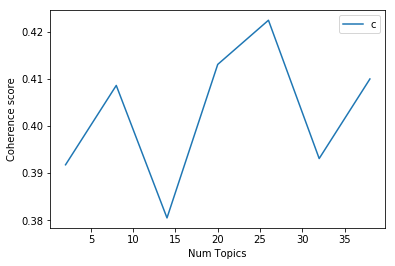

In [57]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3918
Num Topics = 8  has Coherence Value of 0.4086
Num Topics = 14  has Coherence Value of 0.3805
Num Topics = 20  has Coherence Value of 0.413
Num Topics = 26  has Coherence Value of 0.4224
Num Topics = 32  has Coherence Value of 0.3931
Num Topics = 38  has Coherence Value of 0.41


In [59]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.009*"nick" + 0.007*"van" + 0.007*"meet" + 0.007*"natsu" + 0.006*"kuroko" '
  '+ 0.006*"een" + 0.006*"kagami" + 0.005*"release" + 0.005*"song" + '
  '0.005*"ninja"'),
 (1,
  '0.019*"dragon" + 0.013*"cat" + 0.012*"normal" + 0.010*"water" + '
  '0.009*"fire" + 0.009*"dark" + 0.008*"physical" + 0.008*"status" + '
  '0.007*"special" + 0.006*"rock"'),
 (2,
  '0.007*"effect" + 0.006*"choice" + 0.005*"game" + 0.005*"time" + '
  '0.005*"level" + 0.004*"star" + 0.003*"blue" + 0.003*"play" + '
  '0.003*"diamond" + 0.003*"item"'),
 (3,
  '0.008*"week" + 0.007*"team" + 0.006*"episode" + 0.006*"scott" + '
  '0.006*"season" + 0.005*"challenge" + 0.005*"win" + 0.005*"game" + '
  '0.004*"contestant" + 0.004*"show"'),
 (4,
  '0.008*"season" + 0.006*"find" + 0.005*"episode" + 0.005*"kill" + '
  '0.004*"make" + 0.004*"leave" + 0.004*"time" + 0.004*"show" + 0.004*"father" '
  '+ 0.004*"man"'),
 (5,
  '0.017*"damon" + 0.015*"elena" + 0.013*"stefan" + 0.010*"sam" + '
  '0.009*"klaus" + 0.009*"carol